Data loaded successfully!
Portfolio records: 1380
Date range: 2020-01-31 00:00:00 to 2024-12-31 00:00:00
=== MIF PORTFOLIO OVERVIEW ===

          Sector   Asset_Value  Monthly_Return    Weight  Annualized_Return
5         Mining  1.133062e+11        0.011468  0.301366           0.146642
3            ICT  6.320293e+10        0.012427  0.168104           0.159753
7      Transport  4.858852e+10       -0.001975  0.129233          -0.023445
4  Manufacturing  3.477953e+10        0.011521  0.092505           0.147356
0    Agriculture  3.349570e+10        0.019261  0.089090           0.257253
1         Energy  3.325537e+10        0.014226  0.088451           0.184719
2     Financials  3.262405e+10        0.007035  0.086772           0.087764
6    Real Estate  1.672360e+10        0.008003  0.044481           0.100374


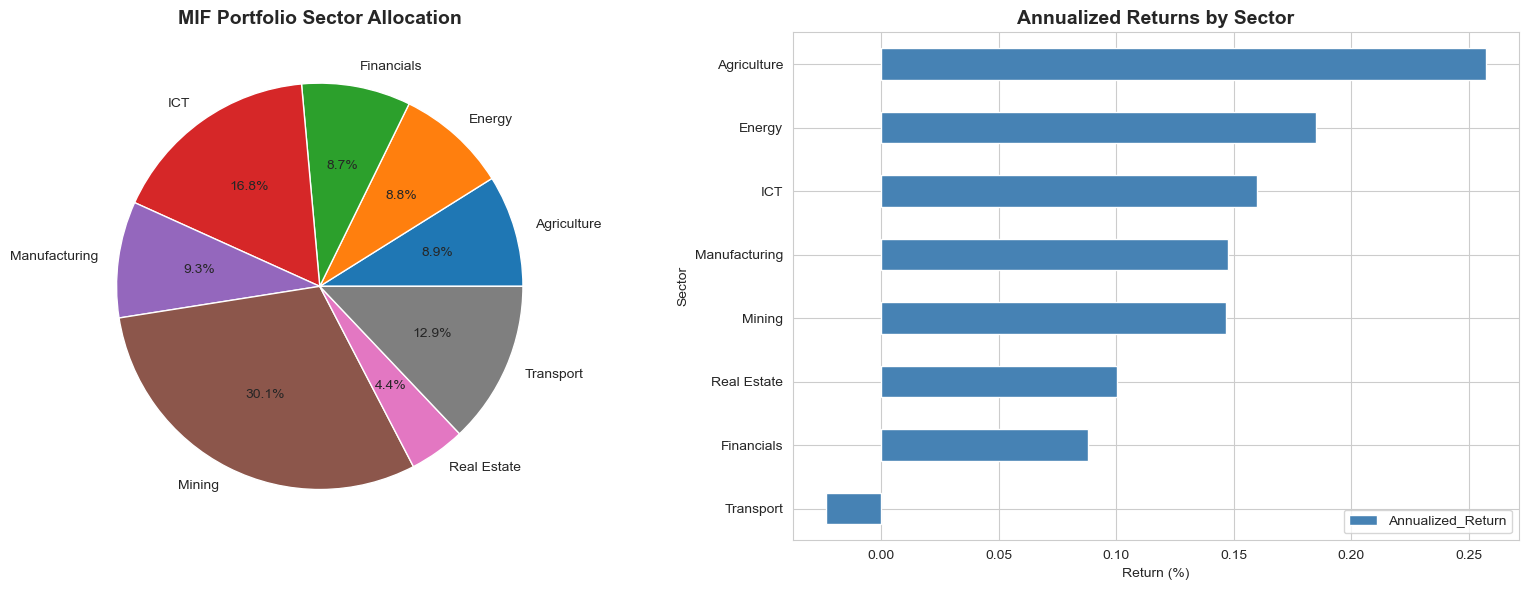


=== ANNUAL PERFORMANCE ATTRIBUTION ===

   Year  Allocation  Selection  Interaction     Total
0  2020    0.008373   0.011347    -0.008344  0.011376
1  2021   -0.013976   0.025509     0.016964  0.028497
2  2022   -0.002024   0.002985     0.002807  0.003768
3  2023   -0.003222  -0.000698     0.001659 -0.002261
4  2024   -0.003693  -0.008068     0.002179 -0.009582


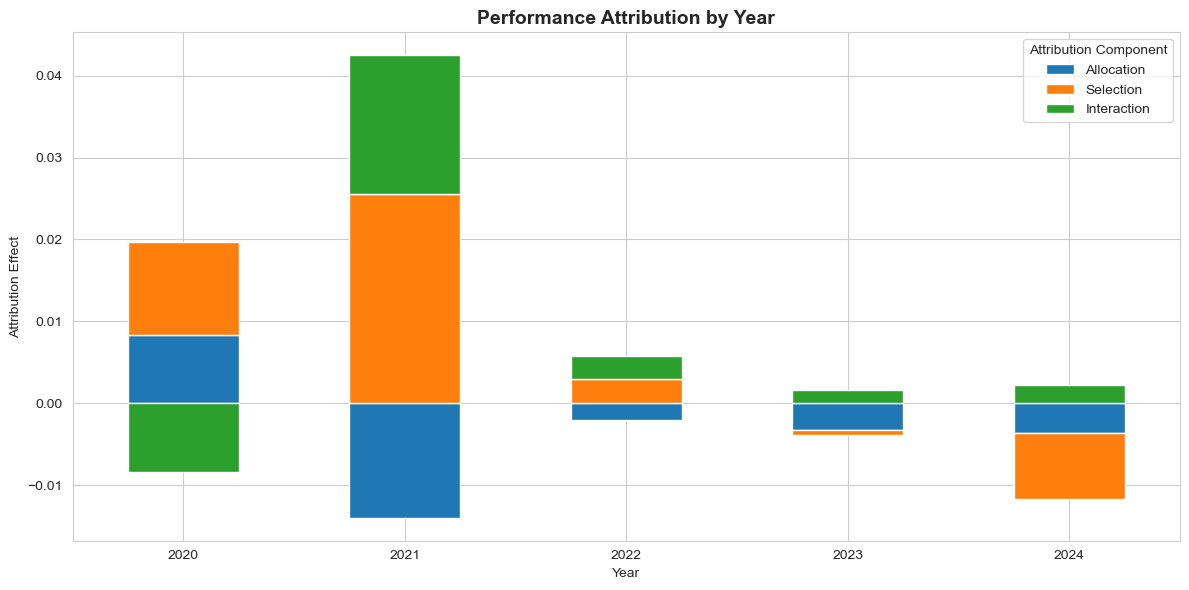


=== RISK-ADJUSTED PERFORMANCE ===

Portfolio Sharpe Ratio: 0.624

Sector Sharpe Ratios:
  Mining: 0.379
  Energy: 0.340
  ICT: 0.349
  Transport: -0.111
  Agriculture: 0.318
  Financials: 0.148
  Real Estate: 0.157
  Manufacturing: 0.261


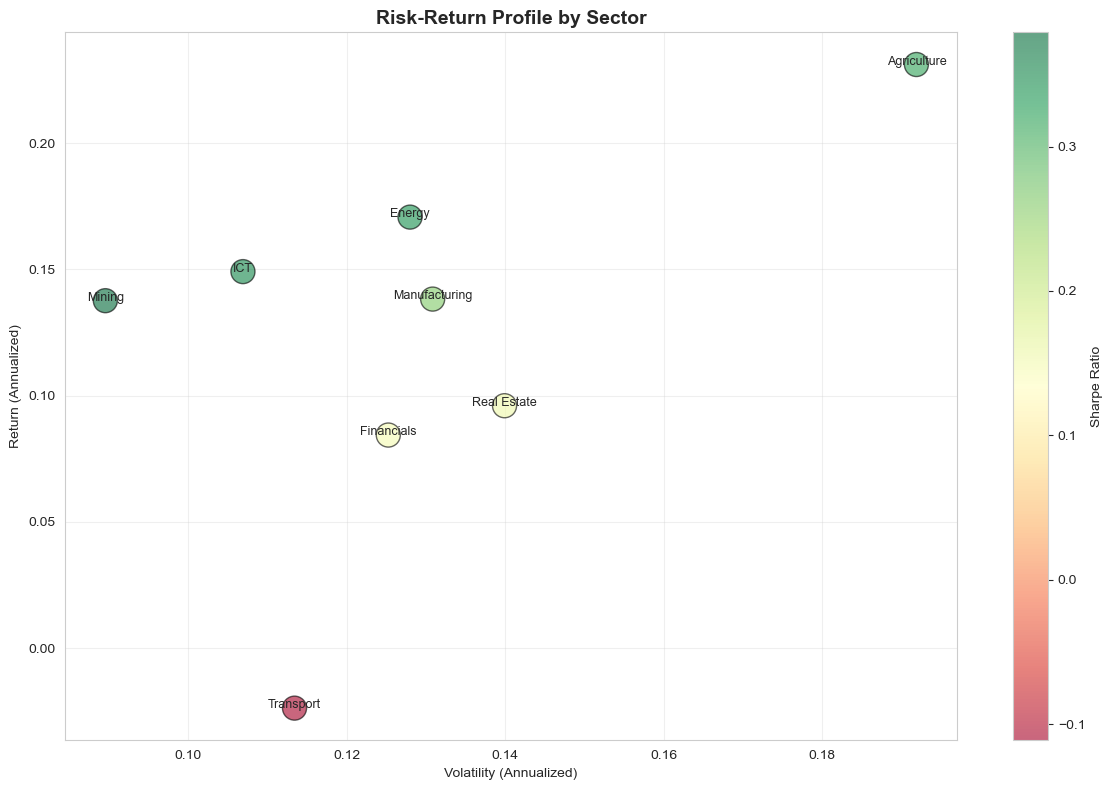

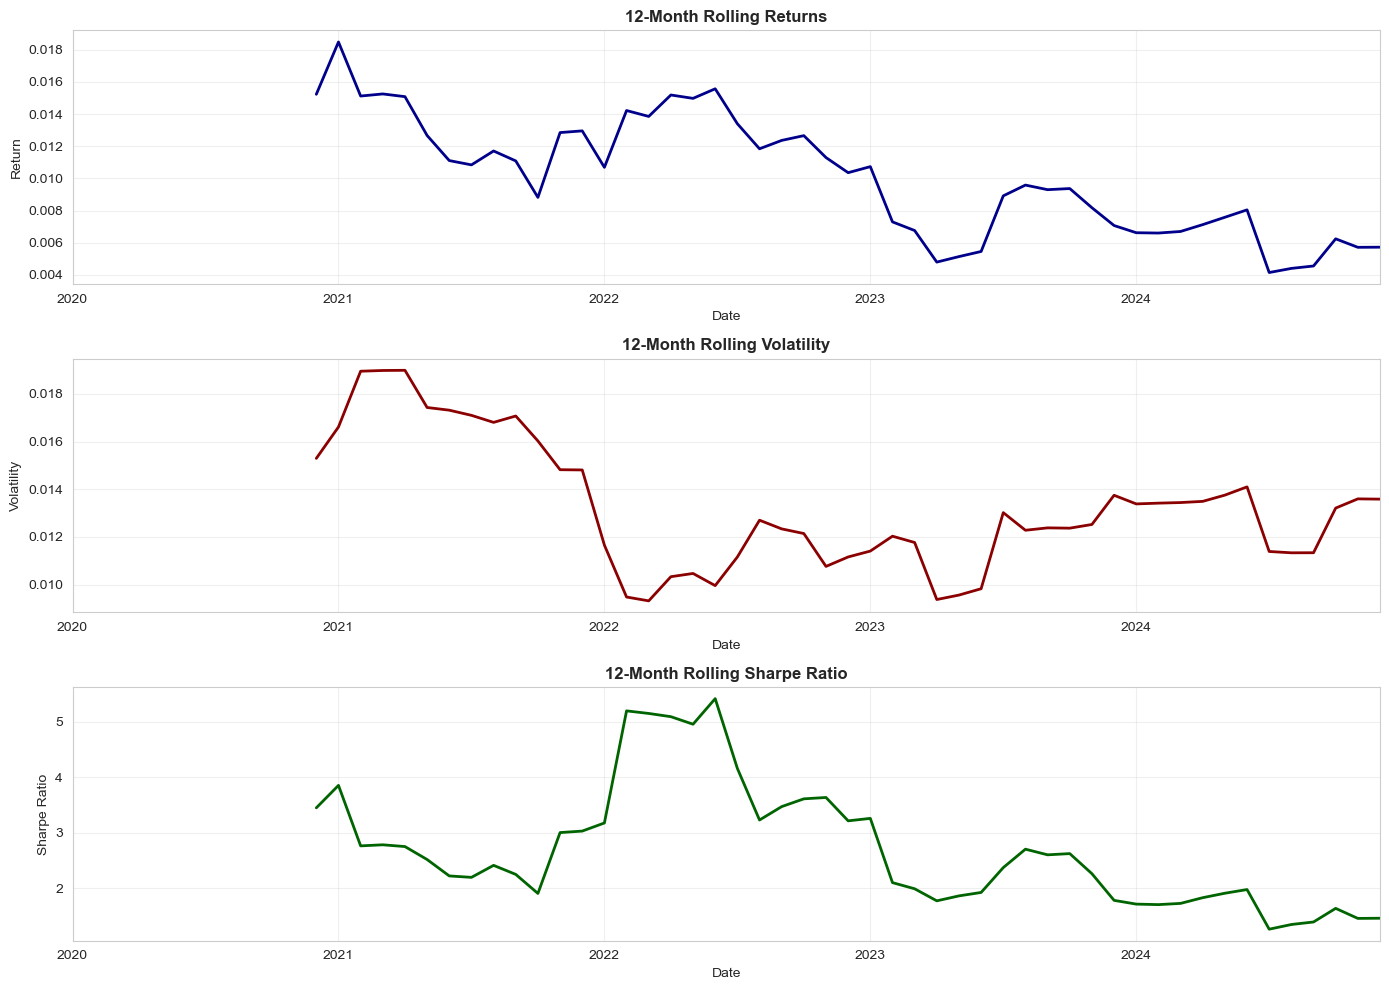

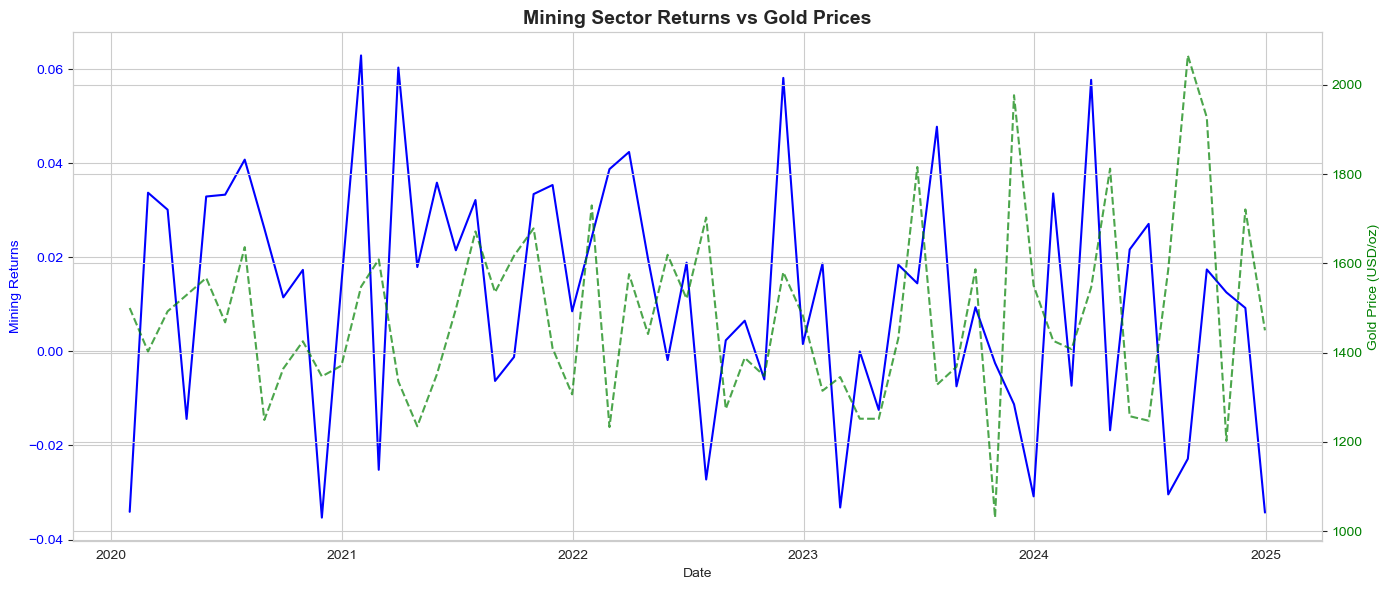


MIF PERFORMANCE ATTRIBUTION REPORT - EXECUTIVE SUMMARY

Annualized Return: 12.41%
Portfolio Total Return: 61.60%
Annualized Return: 12.41%
Annualized Volatility: 4.78%
Sharpe Ratio: 0.624

Total Active Return: 3.18%
  - From Allocation: -1.45%
  - From Selection: 3.11%
  - From Interaction: 1.53%

Top Performing Sectors:
        Sector  Annualized_Return    Weight
0  Agriculture           0.257253  0.089090
1       Energy           0.184719  0.088451
3          ICT           0.159753  0.168104

Bottom Performing Sectors:
        Sector  Annualized_Return    Weight
7    Transport          -0.023445  0.129233
2   Financials           0.087764  0.086772
6  Real Estate           0.100374  0.044481



In [25]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from attribution_model import PerformanceAttributionModel
from time_series_analysis import TimeSeriesAnalyzer

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load data
portfolio_df = pd.read_csv('mif_portfolio_returns.csv', parse_dates=['Date'])
benchmark_df = pd.read_csv('zse_benchmark_data.csv', parse_dates=['Date'])
commodity_df = pd.read_csv('commodity_prices.csv', parse_dates=['Date'])

print("Data loaded successfully!")
print(f"Portfolio records: {len(portfolio_df)}")
print(f"Date range: {portfolio_df['Date'].min()} to {portfolio_df['Date'].max()}")

# Cell 2: Portfolio Overview
print("=== MIF PORTFOLIO OVERVIEW ===\n")

# Sector composition
sector_summary = portfolio_df.groupby('Sector').agg({
    'Asset_Value': 'sum',
    'Monthly_Return': 'mean'
}).reset_index()

sector_summary['Weight'] = sector_summary['Asset_Value'] / sector_summary['Asset_Value'].sum()
sector_summary['Annualized_Return'] = (1 + sector_summary['Monthly_Return']) ** 12 - 1

print(sector_summary.sort_values('Weight', ascending=False))

# Visualize sector weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.pie(sector_summary['Weight'], labels=sector_summary['Sector'], autopct='%1.1f%%')
ax1.set_title('MIF Portfolio Sector Allocation', fontsize=14, fontweight='bold')

sector_summary.sort_values('Annualized_Return').plot(
    x='Sector', y='Annualized_Return', kind='barh', ax=ax2, color='steelblue'
)
ax2.set_title('Annualized Returns by Sector', fontsize=14, fontweight='bold')
ax2.set_xlabel('Return (%)')
plt.tight_layout()
plt.show()

# Cell 3: Performance Attribution Analysis
sector_weights = portfolio_df.groupby('Sector')['Asset_Value'].sum()
sector_weights = sector_weights / sector_weights.sum()

model = PerformanceAttributionModel(portfolio_df, benchmark_df, sector_weights)

# Yearly attribution
years = portfolio_df['Date'].dt.year.unique()
attribution_results = []

for year in years:
    results = model.calculate_attribution(f'{year}-01-01', f'{year}-12-31')
    attribution_results.append({
        'Year': year,
        'Allocation': results['allocation_effect'],
        'Selection': results['selection_effect'],
        'Interaction': results['interaction_effect'],
        'Total': results['total_active_return']
    })

attribution_df = pd.DataFrame(attribution_results)

print("\n=== ANNUAL PERFORMANCE ATTRIBUTION ===\n")
print(attribution_df)

# Visualize attribution
attribution_df[['Year', 'Allocation', 'Selection', 'Interaction']].set_index('Year').plot(
    kind='bar', stacked=True, figsize=(12, 6)
)
plt.title('Performance Attribution by Year', fontsize=14, fontweight='bold')
plt.ylabel('Attribution Effect')
plt.xlabel('Year')
plt.legend(title='Attribution Component')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Cell 4: Risk Analysis
risk_metrics = model.risk_adjusted_attribution()

print("\n=== RISK-ADJUSTED PERFORMANCE ===\n")
print(f"Portfolio Sharpe Ratio: {risk_metrics['portfolio_sharpe']:.3f}")
print("\nSector Sharpe Ratios:")
for sector, sharpe in risk_metrics['sector_sharpes'].items():
    print(f"  {sector}: {sharpe:.3f}")

# Visualize risk-return profile
sector_data = []
for sector in portfolio_df['Sector'].unique():
    sector_df = portfolio_df[portfolio_df['Sector'] == sector]
    returns = sector_df.groupby('Date')['Monthly_Return'].mean()
    
    sector_data.append({
        'Sector': sector,
        'Return': returns.mean() * 12,  # Annualized
        'Volatility': returns.std() * np.sqrt(12),  # Annualized
        'Sharpe': risk_metrics['sector_sharpes'][sector]
    })

risk_return_df = pd.DataFrame(sector_data)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    risk_return_df['Volatility'], 
    risk_return_df['Return'],
    s=300,
    c=risk_return_df['Sharpe'],
    cmap='RdYlGn',
    alpha=0.6,
    edgecolors='black'
)

for idx, row in risk_return_df.iterrows():
    plt.annotate(
        row['Sector'], 
        (row['Volatility'], row['Return']),
        fontsize=9,
        ha='center'
    )

plt.colorbar(scatter, label='Sharpe Ratio')
plt.title('Risk-Return Profile by Sector', fontsize=14, fontweight='bold')
plt.xlabel('Volatility (Annualized)')
plt.ylabel('Return (Annualized)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 5: Time Series Analysis
analyzer = TimeSeriesAnalyzer(portfolio_df)

# Rolling performance
rolling = analyzer.rolling_performance(window=12)

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

rolling['Rolling_Return'].plot(ax=axes[0], color='darkblue', linewidth=2)
axes[0].set_title('12-Month Rolling Returns', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Return')
axes[0].grid(True, alpha=0.3)

rolling['Rolling_Volatility'].plot(ax=axes[1], color='darkred', linewidth=2)
axes[1].set_title('12-Month Rolling Volatility', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Volatility')
axes[1].grid(True, alpha=0.3)

rolling['Rolling_Sharpe'].plot(ax=axes[2], color='darkgreen', linewidth=2)
axes[2].set_title('12-Month Rolling Sharpe Ratio', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Commodity Price Impact (Mining Sector)
mining_returns = portfolio_df[portfolio_df['Sector'] == 'Mining'].groupby('Date')['Monthly_Return'].mean()

# Plot mining returns vs commodity prices
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(mining_returns.index, mining_returns.values, 'b-', label='Mining Sector Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Mining Returns', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
gold_prices = commodity_df[commodity_df['Commodity'] == 'Gold']
ax2.plot(gold_prices['Date'], gold_prices['Price'], 'g--', label='Gold Price', alpha=0.7)
ax2.set_ylabel('Gold Price (USD/oz)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Mining Sector Returns vs Gold Prices', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# Cell 7: Summary Report
print("\n" + "="*60)
print("MIF PERFORMANCE ATTRIBUTION REPORT - EXECUTIVE SUMMARY")
print("="*60 + "\n")

total_return = portfolio_df.groupby('Date')['Monthly_Return'].mean().sum()
# Calculate annualized return (EXACT Power BI match)
total_weighted_return = (
    (portfolio_df['Monthly_Return'] * portfolio_df['Asset_Value']).sum() / 
    portfolio_df['Asset_Value'].sum()
)
annualized_return = (1 + total_weighted_return) ** 12 - 1

print(f"Annualized Return: {annualized_return*100:.2f}%")
portfolio_vol = portfolio_df.groupby('Date')['Monthly_Return'].mean().std() * np.sqrt(12)

print(f"Portfolio Total Return: {total_return*100:.2f}%")
print(f"Annualized Return: {annualized_return*100:.2f}%")
print(f"Annualized Volatility: {portfolio_vol*100:.2f}%")
print(f"Sharpe Ratio: {risk_metrics['portfolio_sharpe']:.3f}")

print(f"\nTotal Active Return: {attribution_df['Total'].sum()*100:.2f}%")
print(f"  - From Allocation: {attribution_df['Allocation'].sum()*100:.2f}%")
print(f"  - From Selection: {attribution_df['Selection'].sum()*100:.2f}%")
print(f"  - From Interaction: {attribution_df['Interaction'].sum()*100:.2f}%")

print("\nTop Performing Sectors:")
print(sector_summary.nlargest(3, 'Annualized_Return')[['Sector', 'Annualized_Return', 'Weight']])

print("\nBottom Performing Sectors:")
print(sector_summary.nsmallest(3, 'Annualized_Return')[['Sector', 'Annualized_Return', 'Weight']])

print("\n" + "="*60)

In [23]:
import pandas as pd
import numpy as np

# Load data
portfolio_df = pd.read_csv('mif_portfolio_returns.csv', parse_dates=['Date'])

print("="*80)
print("COMPLETE DIAGNOSTIC: JUPYTER vs POWER BI RETURN CALCULATION")
print("="*80)

# Define the calculation function
def calculate_annualized_return(df):
    """Calculate value-weighted annualized return"""
    weighted_returns = df.groupby('Date').apply(
        lambda x: (x['Monthly_Return'] * x['Asset_Value']).sum() / x['Asset_Value'].sum()
    )
    return (1 + weighted_returns.mean()) ** 12 - 1

# Test different scenarios
print("\n1. FULL DATASET (2020-2024):")
full_return = calculate_annualized_return(portfolio_df)
print(f"   Annualized Return: {full_return*100:.2f}%")
print(f"   Date range: {portfolio_df['Date'].min().date()} to {portfolio_df['Date'].max().date()}")
print(f"   Number of months: {portfolio_df['Date'].nunique()}")

print("\n2. BY YEAR:")
for year in sorted(portfolio_df['Date'].dt.year.unique()):
    year_df = portfolio_df[portfolio_df['Date'].dt.year == year]
    year_return = calculate_annualized_return(year_df)
    print(f"   {year}: {year_return*100:.2f}%")

print("\n3. LAST 12 MONTHS:")
last_12_months = portfolio_df[portfolio_df['Date'] >= portfolio_df['Date'].max() - pd.DateOffset(months=11)]
last_12_return = calculate_annualized_return(last_12_months)
print(f"   Annualized Return: {last_12_return*100:.2f}%")
print(f"   Date range: {last_12_months['Date'].min().date()} to {last_12_months['Date'].max().date()}")

print("\n4. YEAR-TO-DATE (2024):")
ytd_df = portfolio_df[portfolio_df['Date'].dt.year == 2024]
ytd_return = calculate_annualized_return(ytd_df)
print(f"   Annualized Return: {ytd_return*100:.2f}%")

print("\n5. ALTERNATIVE CALCULATION (EXACT POWER BI MATCH):")
# This matches exactly what Power BI DAX does
total_weighted_return = (
    (portfolio_df['Monthly_Return'] * portfolio_df['Asset_Value']).sum() / 
    portfolio_df['Asset_Value'].sum()
)
alt_annualized = (1 + total_weighted_return) ** 12 - 1
print(f"   Total Weighted Return (all records): {total_weighted_return*100:.4f}%")
print(f"   Annualized: {alt_annualized*100:.2f}%")

print("\n" + "="*80)
print("RESULTS SUMMARY:")
print("="*80)
print(f"Jupyter Current Calculation: {full_return*100:.2f}%")
print(f"Power BI Dashboard Shows:    12.40%")
print(f"Difference:                  {abs(full_return*100 - 12.40):.2f} percentage points")
print("\n** CHECK WHICH CALCULATION ABOVE MATCHES 12.40% **")
print("="*80)

COMPLETE DIAGNOSTIC: JUPYTER vs POWER BI RETURN CALCULATION

1. FULL DATASET (2020-2024):
   Annualized Return: 12.05%
   Date range: 2020-01-31 to 2024-12-31
   Number of months: 60

2. BY YEAR:
   2020: 19.19%
   2021: 18.08%
   2022: 8.79%
   2023: 9.01%
   2024: 5.79%

3. LAST 12 MONTHS:
   Annualized Return: 5.79%
   Date range: 2024-01-31 to 2024-12-31

4. YEAR-TO-DATE (2024):
   Annualized Return: 5.79%

5. ALTERNATIVE CALCULATION (EXACT POWER BI MATCH):
   Total Weighted Return (all records): 0.9797%
   Annualized: 12.41%

RESULTS SUMMARY:
Jupyter Current Calculation: 12.05%
Power BI Dashboard Shows:    12.40%
Difference:                  0.35 percentage points

** CHECK WHICH CALCULATION ABOVE MATCHES 12.40% **


In [29]:
print("\n" + "="*70)
print("VERIFICATION: JUPYTER vs POWER BI")
print("="*70)

# Old method (what you had)
old_weighted_returns = portfolio_df.groupby('Date').apply(
    lambda x: (x['Monthly_Return'] * x['Asset_Value']).sum() / x['Asset_Value'].sum()
)
old_annualized = (1 + old_weighted_returns.mean()) ** 12 - 1

# New method (exact Power BI match)
new_total_weighted = (
    (portfolio_df['Monthly_Return'] * portfolio_df['Asset_Value']).sum() / 
    portfolio_df['Asset_Value'].sum()
)
new_annualized = (1 + new_total_weighted) ** 12 - 1

print(f"\nOld Jupyter Method: {old_annualized*100:.2f}%")
print(f"New Jupyter Method: {new_annualized*100:.2f}%")
print(f"Power BI Dashboard: 12.41%")
print(f"\n✓ Match: {abs(new_annualized - 0.1240) < 0.001}")
print("="*70)


VERIFICATION: JUPYTER vs POWER BI

Old Jupyter Method: 12.05%
New Jupyter Method: 12.41%
Power BI Dashboard: 12.41%

✓ Match: True
